# DeepFeatures Testing around

In [208]:
# surpress UserWarnings
# import warnings
# warnings.filterwarnings("ignore")

# basic packages
from importlib_metadata import version
import platform
print('The Python version is {}.'.format(platform.python_version()))
import os
import random
import time

# data handling
import numpy as np
print('The numpy version is {}.'.format(version('numpy')))
import pandas as pd
print('The pandas version is {}.'.format(version('pandas')))
import xarray as xr
print('The xarray version is {}.'.format(version('xarray')))
import rasterio
print('The rasterio version is {}.'.format(version('rasterio')))
import rioxarray
print('The rioxarray version is {}.'.format(version('rioxarray')))
import pyproj
print('The pyproj version is {}.'.format(version('pyproj')))
import folium
print('The folium version is {}.'.format(version('folium')))
import datetime
## xcube stuff
from xcube.core.store import new_data_store
from xcube.core.maskset import MaskSet
print('The xcube version is {}.'.format(version('xcube')))
import spyndex
print('The spyndex version is {}.'.format(version('spyndex')))

# AI
## torch
import torch
print('The torch version is {}.'.format(version('torch')))
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
## torchvision
import torchvision
print('The torchvision version is {}.'.format(version('torchvision')))
from torchvision.transforms import v2
## lightning
import lightning as L
print('The Lightning version is {}.'.format(version('lightning')))
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.accelerators import find_usable_cuda_devices

# plotting
# jupyter
import IPython.display
from IPython.display import GeoJSON
print('The IPython version is {}.'.format(version('IPython')))
import shapely.geometry
# plot libs
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
print('The matplotlib version is {}.'.format(version('matplotlib')))
import seaborn as sns
print('The Seaborn version is {}.'.format(version('matplotlib')))

The Python version is 3.11.13.
The numpy version is 1.26.4.
The pandas version is 2.2.3.
The xarray version is 2024.9.0.
The rasterio version is 1.4.3.
The rioxarray version is 0.19.0.
The pyproj version is 3.7.2.
The folium version is 0.20.0.
The xcube version is 1.12.0.
The spyndex version is 0.6.0.
The torch version is 2.8.0.
The torchvision version is 0.24.0.
The Lightning version is 2.4.0.
The IPython version is 9.3.0.
The matplotlib version is 3.10.7.
The Seaborn version is 3.10.7.


In [209]:
import torch
print('The torch version is {}.'.format(version('torch')))

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
available_devices = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
#available_devices = [range(torch.cuda.device_count())]
print(f"Found {len(available_devices)} CUDA Devices:")

for idx, gpu_id in enumerate(available_devices):
    print(f"{idx:02}: {torch.cuda.get_device_name(gpu_id)}")

The torch version is 2.8.0.
Is CUDA supported by this system? False
CUDA version: None
Found 0 CUDA Devices:


In [210]:
store_team=new_data_store(
            "s3",
            root=os.environ["S3_USER_STORAGE_BUCKET"],
            max_depth=4,
            storage_options=dict(
                anon=False,
                key=os.environ["S3_USER_STORAGE_KEY"],
                secret=os.environ["S3_USER_STORAGE_SECRET"],
            )
)
list = store_team.list_data_ids();
# ds = store_team.open_data("cubes/science/0.1.0/047.zarr")

## Cube plotting

* Picks a random cube
* shows ESA WC
* then checks SCL to show the amount of "good pixels" along time
* shows 6 RGB picks from good scenes
* shows according SCL
* shows Cloud mask (Cloudsen12)
* Show location on GeoJSON Map

cubes/training/0.1.0/3632_0.zarr
Start: 2023-09-30T09:17:09.024000000
End:   2024-09-29T09:20:31.024000000


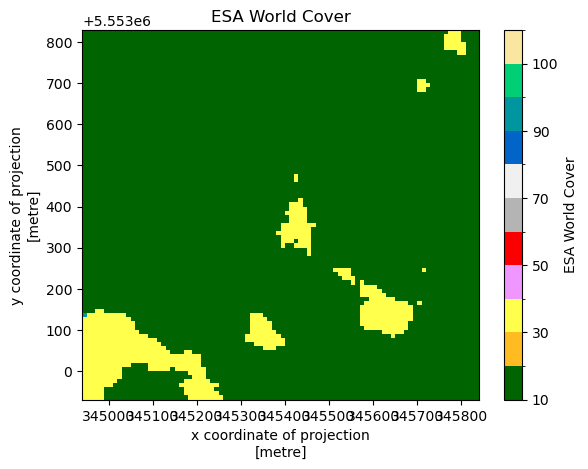

In [219]:
filtered = [p for p in list if "cubes/training/0.1.0" in p]
cube_string = random.choice(filtered)
print(cube_string)
cube = store_team.open_data(cube_string)
# cube = store_team.open_data("cubes/training/0.1.0/0257_0.zarr")
start = cube.time.min().values
end   = cube.time.max().values
print("Start:", str(start))
print("End:  ", str(end))
esa_wc_mask = MaskSet(cube.esa_wc)
cmap, norm = esa_wc_mask.get_cmap()
cube.esa_wc.plot(cmap=cmap, norm=norm)
plt.title("ESA World Cover")
good_classes = [4, 5, 6, 7]  # vegetation, not_vegetation, water, unclassified
good_mask = cube.scl.isin(good_classes)  # True where pixel is good

Text(0.5, 1.0, 'Good Pixels per Scene')

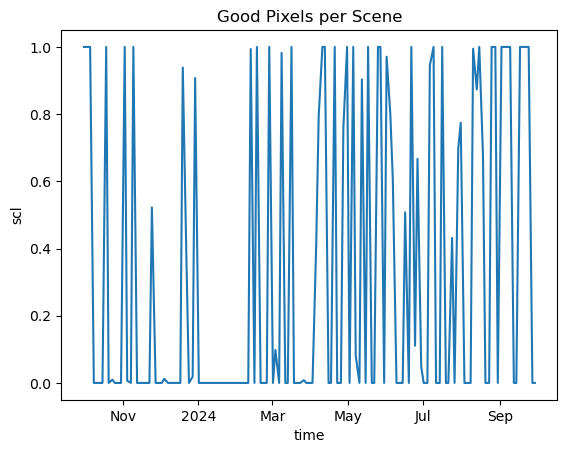

In [220]:
clear_fraction = good_mask.mean(dim=("x", "y")).compute()  # fraction of good pixels per time
clear_fraction.plot()
plt.title("Good Pixels per Scene")

RGB Images of good scenes
SCL Layer for RGB
CloudSen for RGB


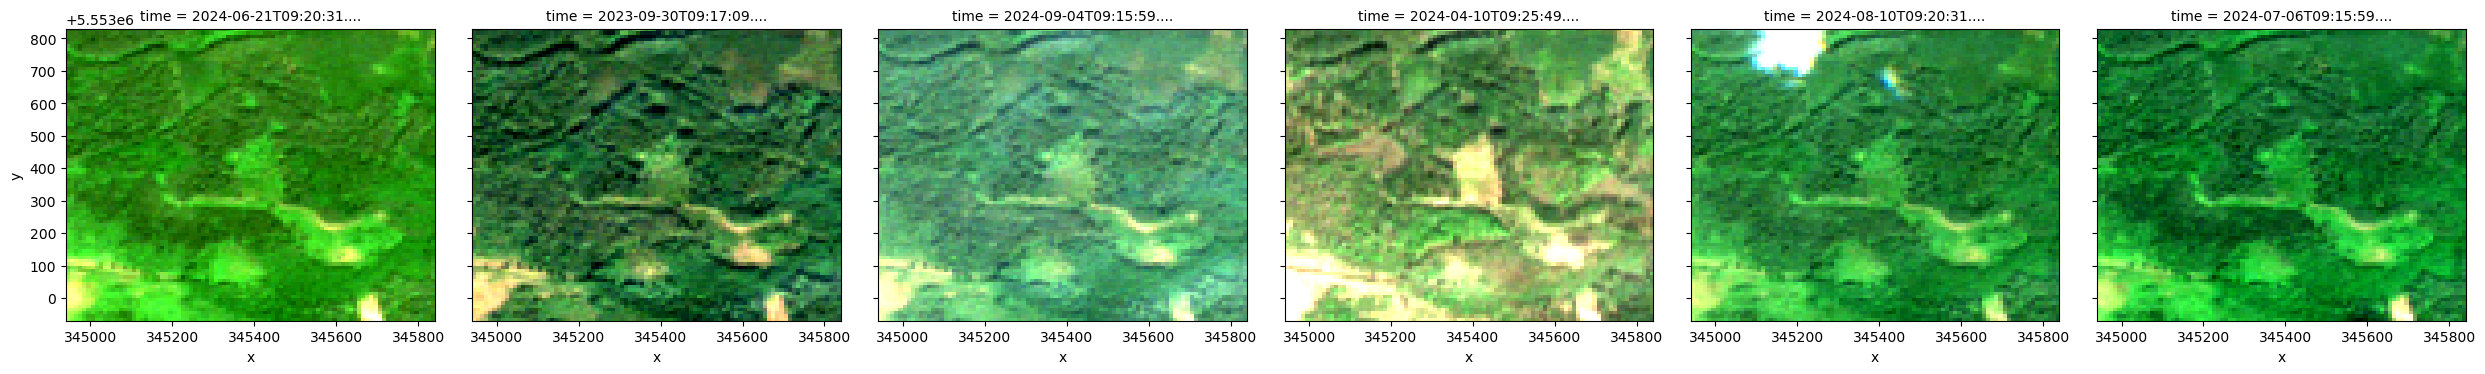

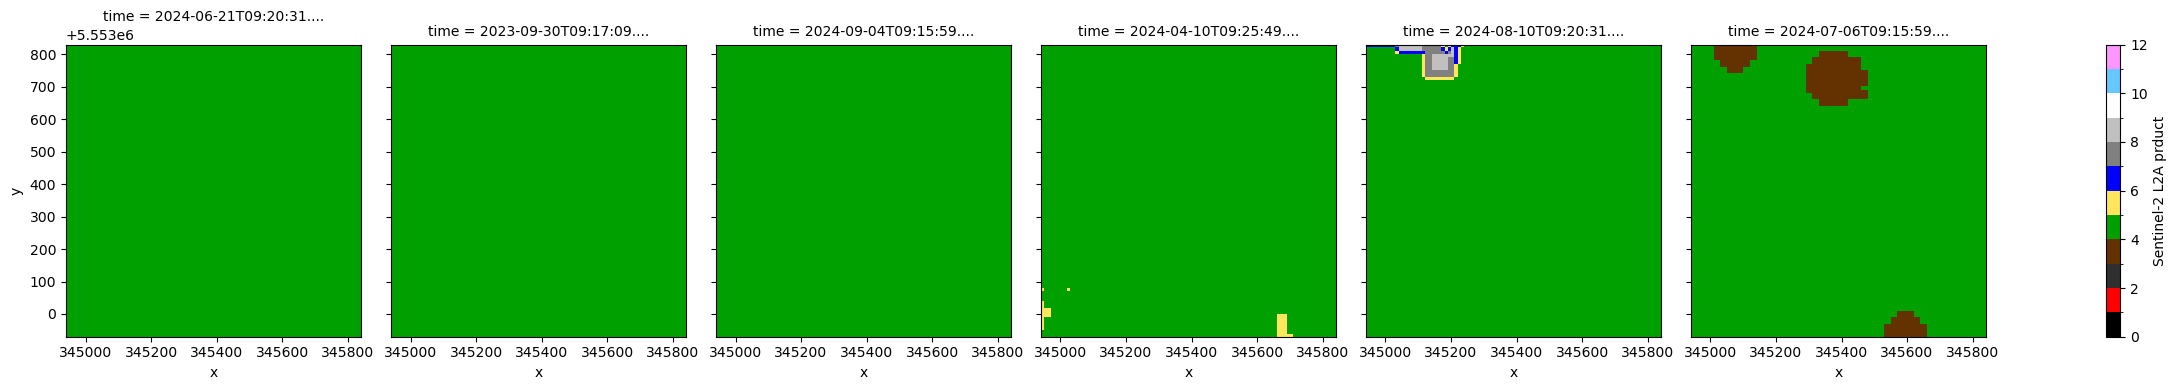

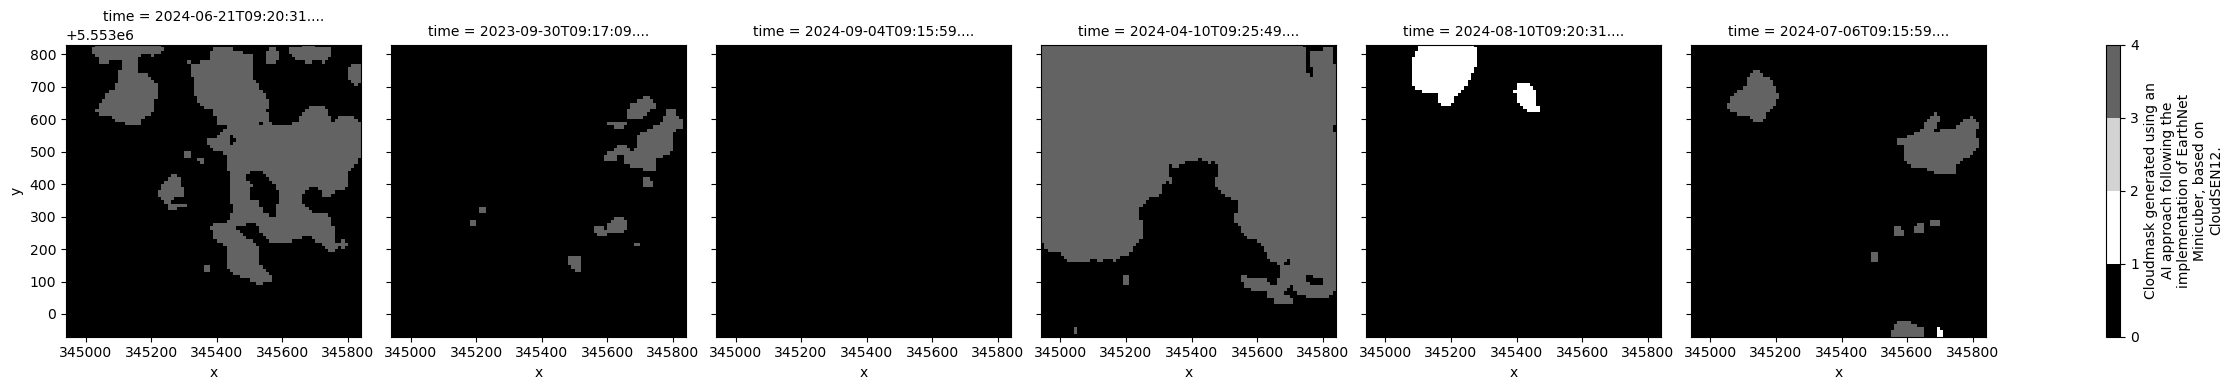

In [226]:
threshold = 0.9  # at least 90% good pixels
good_times = clear_fraction.where(clear_fraction >= threshold, drop=True)
rgb_good = cube.s2l2a.sel(band=["B04","B03","B02"]).sel(time=good_times.time)
ntime = rgb_good.sizes["time"]
times = random.sample(range(ntime), 6)

rgb = rgb_good.isel(time=times)
rgb.plot.imshow(
    robust=True,
    aspect=1,
    col="time",
    # col_wrap=6,
    size=4,
)
print("RGB Images of good scenes")

scl = cube.scl.sel(time=good_times.time).isel(time=times)
scl_mask = MaskSet(cube.scl)
cmap, norm = scl_mask.get_cmap()
scl.plot.imshow(
    robust=True,
    aspect=1,
    col="time",
    # col_wrap=6,
    size=4,
    cmap=cmap,
    norm = norm,
)
print("SCL Layer for RGB")

cloudmask = cube.cloud_mask.sel(time=good_times.time).isel(time=times)
cloud_mask_mask = MaskSet(cube.cloud_mask)
cmap, norm = cloud_mask_mask.get_cmap()
cloudmask.plot.imshow(
    robust=True,
    aspect=1,
    col="time",
    # col_wrap=6,
    size=4,
    cmap=cmap,
    norm=norm,
)
print("CloudSen for RGB")

In [227]:
min_lon, min_lat, max_lon, max_lat = cube.attrs['bbox_wgs84']

# GeoJSON Polygon coordinates (must be closed, so first = last point)
polygon = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [min_lon, min_lat],
            [min_lon, max_lat],
            [max_lon, max_lat],
            [max_lon, min_lat],
            [min_lon, min_lat]
        ]]
    },
    "properties": {
        "id": cube.attrs.get("id"),
        "cube_type": cube.attrs.get("cube_type"),
        "project": cube.attrs.get("project"),
    }
}
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
folium.GeoJson(polygon, name="Cube").add_to(m)
m